## Модель на корпусе текстов советской фантастики

Для анализа я выбрала подборку советской фантастики про космос - 11 книг. Напишем функцию, которая будет подготавливать тексты для обучения модели:

In [5]:
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

morph = MorphAnalyzer()
stops = set(stopwords.words('russian') + ['это', 'весь', 'который', 'мочь', 'свой'])

In [7]:
def lemmatize(x):
    if type(x) != str:
        return ""
    text = wordpunct_tokenize(x)
    result = []
    for word in text:
        if word.isalpha():
            nf = morph.parse(word)[0].normal_form
            if nf not in stops:
                result.append(nf)
    return " ".join(result)
    

Эта функция делит текст из файла на предложения, лемматизирует и токенизирует:

In [3]:
def tokenize(filename):
    with open ('books/' + filename, 'r', encoding="utf-8") as f:
        text = f.read()
        tokenized = sent_tokenize(text)
        result= ""
        for sent in tokenized:
           result = result + lemmatize(sent) + '\n'
        return result

Применяем функцию ко всем файлам с книгами:

In [5]:
import os
list_of_files = os.listdir("books")
print(list_of_files)
with open ('cosmos.txt', 'a', encoding="utf-8") as file:
    for f in list_of_files:
        print(f)
        print(tokenize(f), file=file)

['strana.txt', 'asgods_1.txt', 'redplanet.txt', 'asgods_2.txt', 'jumpnoth.txt', 'iya.txt', 'mekong.txt', 'kallisto.txt', 'aelita.txt', 'asgods_3.txt', 'almatea.txt']
strana.txt
asgods_1.txt
redplanet.txt
asgods_2.txt
jumpnoth.txt
iya.txt
mekong.txt
kallisto.txt
aelita.txt
asgods_3.txt
almatea.txt


In [6]:
import gensim
import logging
import urllib.request

import warnings
warnings.filterwarnings('ignore')

In [7]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
f = 'cosmos.txt'
data = gensim.models.word2vec.LineSentence(f)
%time model_cosmos = gensim.models.Word2Vec(data, vector_size=300, window=5, min_count=5, epochs=50)

2021-11-06 18:14:56,816 : INFO : collecting all words and their counts
2021-11-06 18:14:56,819 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-06 18:14:56,871 : INFO : PROGRESS: at sentence #10000, processed 64516 words, keeping 11249 word types
2021-11-06 18:14:56,928 : INFO : PROGRESS: at sentence #20000, processed 125354 words, keeping 15677 word types
2021-11-06 18:14:56,979 : INFO : PROGRESS: at sentence #30000, processed 189878 words, keeping 19147 word types
2021-11-06 18:14:57,024 : INFO : PROGRESS: at sentence #40000, processed 250679 words, keeping 23332 word types
2021-11-06 18:14:57,069 : INFO : PROGRESS: at sentence #50000, processed 310712 words, keeping 26366 word types
2021-11-06 18:14:57,110 : INFO : PROGRESS: at sentence #60000, processed 372166 words, keeping 27743 word types
2021-11-06 18:14:57,167 : INFO : PROGRESS: at sentence #70000, processed 432345 words, keeping 29270 word types
2021-11-06 18:14:57,173 : INFO : collected 2939

CPU times: user 1min 32s, sys: 3.22 s, total: 1min 35s
Wall time: 37.3 s


In [8]:
model_cosmos.init_sims(replace=True)
model_path = "cosmos.bin"
model_cosmos.wv.save_word2vec_format(model_path, binary=True)

2021-11-06 18:15:42,445 : WARNING : destructive init_sims(replace=True) deprecated & no longer required for space-efficiency
2021-11-06 18:15:42,461 : INFO : storing 11008x300 projection weights into cosmos.bin


Посмотрим, сколько в словаре слов:

In [9]:
print(len(model_cosmos.wv.key_to_index))

11008


Слов много, в целом, это хорошо, но может затруднить выполнение семантических задач. 

Попробуем найти ближайшие 10 слов к *космосу*:

In [10]:
model_cosmos.wv.most_similar("космос", topn=10)

[('простор', 0.5031787753105164),
 ('пылевой', 0.4858982264995575),
 ('разверзнуться', 0.48340243101119995),
 ('пространство', 0.4728526473045349),
 ('туманность', 0.4683917164802551),
 ('пустота', 0.4451279044151306),
 ('расширяться', 0.4319530129432678),
 ('коллапсар', 0.42654967308044434),
 ('разлетаться', 0.42319756746292114),
 ('безмолвие', 0.4156072437763214)]

Результат достаточно ожидаем: все слова, которые выделила модель, так или иначе связаны с космосом. В выдаче видим преимущественно синонимы - *пространство, простор, пустота*, а также связанные слова - *туманность, коллапсар*. Поскольку корпус изначально собран на научно-фантастических книгах о космических приключениях, такой результат неудивителен: чтобы придать тексту выразительность, авторы использовали синонимы, специальную лексику -- например, *коллапсар*

In [11]:
model_cosmos.wv.most_similar("аэлит", topn=10) #имя героини - Аэлита, но морфологический анализатор решил иначе

[('аиу', 0.590470552444458),
 ('лось', 0.49761906266212463),
 ('гусев', 0.4963341951370239),
 ('ихошка', 0.49486884474754333),
 ('прижаться', 0.47197866439819336),
 ('пепельный', 0.466469407081604),
 ('капюшон', 0.46589982509613037),
 ('иха', 0.43821343779563904),
 ('катя', 0.437086284160614),
 ('щека', 0.4279519319534302)]

В выдаче видим фамилии других героев "Аэлиты" - Лося и Гусева, имя Катя, Иха (Ихошка) -- в романе это служанка Аэлиты. Кроме того, модель выделила слово *пепельный*, которое фигурирует в описании внешности героини: у нее были пепельные волосы и пепельные глаза. Интересно, что представлено слово *аиу* -- в романе это одно из слов марсианского языка. 

Посмотрим на синонимы и антонимы:

In [12]:
model_cosmos.wv.most_similar(positive=["красивый"], negative=["уродливый"], topn=10)

[('уважать', 0.334258496761322),
 ('супруг', 0.3256406784057617),
 ('содержательный', 0.31614941358566284),
 ('спокойный', 0.31056082248687744),
 ('спасибо', 0.30203527212142944),
 ('приятный', 0.3009944558143616),
 ('словечко', 0.29796844720840454),
 ('деятельный', 0.2957363426685333),
 ('звучный', 0.2918040454387665),
 ('дорого', 0.29107123613357544)]

В выдаче достаточно много прилагательных - содержательный, спокойный, приятный, деятельный, звучный, которые имеют в основном положительную коннотацию, но синонимами или антонимами для красивый/уродливый не являются

Попробуем найти лишнее слово в ряду. Ожидается, что модель выберет слово *Земля*, поскольку в книгах о космосе другие планеты зачастую противопоставлены Земле:

In [13]:
model_cosmos.wv.doesnt_match("земля марс венера юпитер".split())

'земля'

И действительно, модель работает верно. 

## Работа с сайтом rusvectores

In [14]:
urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x7f659646d550>)

In [15]:
m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)

2021-11-06 18:19:06,147 : INFO : loading projection weights from ruscorpora_mystem_cbow_300_2_2015.bin.gz
2021-11-06 18:19:11,025 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (281776, 300) matrix of type float32 from ruscorpora_mystem_cbow_300_2_2015.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-11-06T18:19:11.025604', 'gensim': '4.1.2', 'python': '3.8.10 (default, Jun  2 2021, 10:49:15) \n[GCC 9.4.0]', 'platform': 'Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'load_word2vec_format'}


Попробуем составить семантическую пропорцию женщина - девочка + мужчина = мальчик. Посмотрим, каким будет результат модели:

In [16]:
print(model.most_similar(positive=['женщина_S', 'мужчина_S'], negative=['девочка_S'])[0][0])

человек_S


Вместо *мальчика* получили *человека*, то есть исходная пропорция в понимании модели выглядит так: *женщина - девочка = мужчина - человек*

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

Попробуем сделать визуализацию для абстрактных понятий:

In [18]:
words = ['смерть_S', 'страдание_S', 'любовь_S','одиночество_S', 'преданность_S', 'ненависть_S', 'дружба_S', 'верность_S', 'печаль_S', 'обожание_S', 'радость_S']
X = model[words]

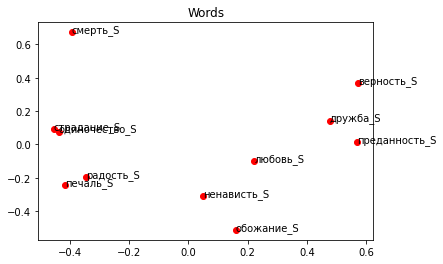

In [20]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

В целом, результат противоречивый: с одной стороны, в визуализации близки слова верность, дружба, преданность,  а также страдание и одиночество, что соответсвтвует действительности. С другой -- ненависть оказалась ближе к любви, чем обожание, печаль и радость рядом. 

Возьмем первое предложение из романа "Мастер и Маргарита", лемматизируем и уберем служебные слова. Чтобы формат записи предложения совпал с форматом, который принимает наша модель, используем mystem, добавим частеречные тэги:

In [21]:
from pymystem3 import Mystem
m = Mystem()

In [22]:
sent = "Однажды весной, в час небывало жаркого заката, в Москве, на Патриарших прудах, появились два гражданина."
sent_lemmatized = lemmatize(sent).split()
sent_parsed = []
for word in sent_lemmatized:
    ana = m.analyze(word)
    gr = ana[0]['analysis'][0]['gr']
    pos = gr.split('=')[0].split(',')[0]
    sent_parsed.append(ana[0]['text'] + '_' + pos)

Применим модель к каждому слову:

In [23]:
res = []
for word in sent_parsed:
    smword = model.most_similar(word, topn=1)[0][0]
    res.append(smword)
res

['вчера_ADV',
 'осень_S',
 'полчаса_S',
 'невиданный_A',
 'знойный_A',
 'закатный_A',
 'петербург_S',
 'патриерший_S',
 'озеро_S',
 'эллис_S',
 'гражданство_S']

Получается такое предложение: *Вчера осенью, в полчаса невиданного знойного закатного, в Петербурге, на Патриершем озере, эллис (?) два гражданства.*

## TF-IDF

Возьмем статьи из Википедии из категории "мультфильмы о ведьмах" (https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D1%84%D0%B8%D0%BB%D1%8C%D0%BC%D1%8B_%D0%BE_%D0%B2%D0%B5%D0%B4%D1%8C%D0%BC%D0%B0%D1%85)

In [2]:
import wikipedia
from tqdm.auto import tqdm
wikipedia.set_lang('ru')
article_names = ["Белоснежка и семь гномов (мультфильм)", "Ведьмина служба доставки", "Верхом на помеле (мультфильм)", "Дети против волшебников (мультфильм)", "Добрыня Никитич и Змей Горыныч", "Дракон и тапочка королевы", "Карлик Нос (мультфильм)", "Маленькая колдунья (мультфильм)", "Мальчик из Неаполя", "Меч в камне (мультфильм)", "Мэри и ведьмин цветок", "Ореховый прутик", "Паранорман, или Как приручить зомби", "Рапунцель: Запутанная история", "Русалочка (мультфильм, 1989)", "Русалочка 2: Возвращение в море", "Скуби-Ду и призрак ведьмы", "Скуби-Ду и Школа вампиров", "Скуби-Ду, где ты!", "Спящая красавица (мультфильм)", "Три богатыря на дальних берегах", "Унесённые призраками", "Храбрая сердцем", "Bewitched Bunny", "Brynhildr in the Darkness", "Rosario + Vampire"]

articles = []
for page_name in tqdm(article_names):
    try:
        text = wikipedia.page(page_name).content
        articles.append((page_name, text))
    except:
        print("Error", page_name)

  0%|          | 0/26 [00:00<?, ?it/s]

Подготовим TF-IDF, введем необходимые параметры:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
tfidf = TfidfVectorizer(
    analyzer="word",
    stop_words=stops,
    ngram_range = (1, 3), #число слов
    min_df = 3 #минимальное число вхождений
)

Подготовим тексты статей, лемматизируем, избавимся от знаков препинания:

In [9]:
articles_preprocessed = []
for a_text in articles:
    a_lemmatized = lemmatize(a_text[1])
    articles_preprocessed.append(a_lemmatized)

Пропускаем через TF-IDF:

In [10]:
articles_tfidf = tfidf.fit_transform(articles_preprocessed)
print(f"Матрица на {articles_tfidf.shape[0]} документов и {articles_tfidf.shape[1]} термов")

Матрица на 26 документов и 2056 термов


Выделим для каждой статьи ключевые слова:

In [14]:
import numpy as np
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

In [14]:
feature_names = np.array(tfidf.get_feature_names())

for i, article in enumerate(articles):
    article_vector = articles_tfidf[i, :]
    words = get_top_tf_idf_words(article_vector, feature_names, 10)
    print(article[0])
    print(words)

Белоснежка и семь гномов (мультфильм)
['белоснежок' 'гном' 'дисней' 'королева' 'семь гном' 'уолт' 'год' 'семь'
 'фильм' 'мультфильм']
Ведьмина служба доставки
['фильм' 'японский' 'служба' 'книга' 'яп' 'аниме' 'её' 'кот' 'год' 'город']
Верхом на помеле (мультфильм)
['фильм' 'кот' 'птица' 'дракон' 'книга' 'ведьма' 'пёс' 'верхом'
 'фильм сайт' 'информация']
Дети против волшебников (мультфильм)
['иван' 'фильм' 'мультфильм' 'разработчик' 'российский' 'волшебник'
 'картина' 'фонд' 'ребёнок' 'поддержка']
Добрыня Никитич и Змей Горыныч
['змея' 'хан' 'игра' 'однако' 'выдать' 'приказ' 'издаваться' 'год'
 'мультфильм' 'предлагать']
Дракон и тапочка королевы
['королева' 'король' 'артур' 'дракон' 'король артур' 'пирог' 'рыцарь'
 'мерлина' 'зелье' 'время']
Карлик Нос (мультфильм)
['фестиваль' 'колдунья' 'детский' 'оригинал' 'международный' 'год' 'фильм'
 'семь год' 'приз' 'мультфильм']
Маленькая колдунья (мультфильм)
['мультфильм' 'книга' 'геннадий' 'ведьма' 'старушка' 'колдунья' 'главный'
 'маленьк

/home/zadushevno/hws/hw3/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


В целом для многих статей ключевые слова отражают содержание, но не для всех. Обычно в ключевые слова попадают имена героев, важные предметы. Часто вместо содержания ключевые статьи отражают год и страну производства. 

Когда я пыталась сделать визуализацию с помощью PCA, программа выдавала ошибку (*PCA does not support sparse input. See TruncatedSVD for a possible alternative*), которую я так и не поняла, как исправить, и предлагала использовать TruncatedSVD, что я в итоге и сделала:

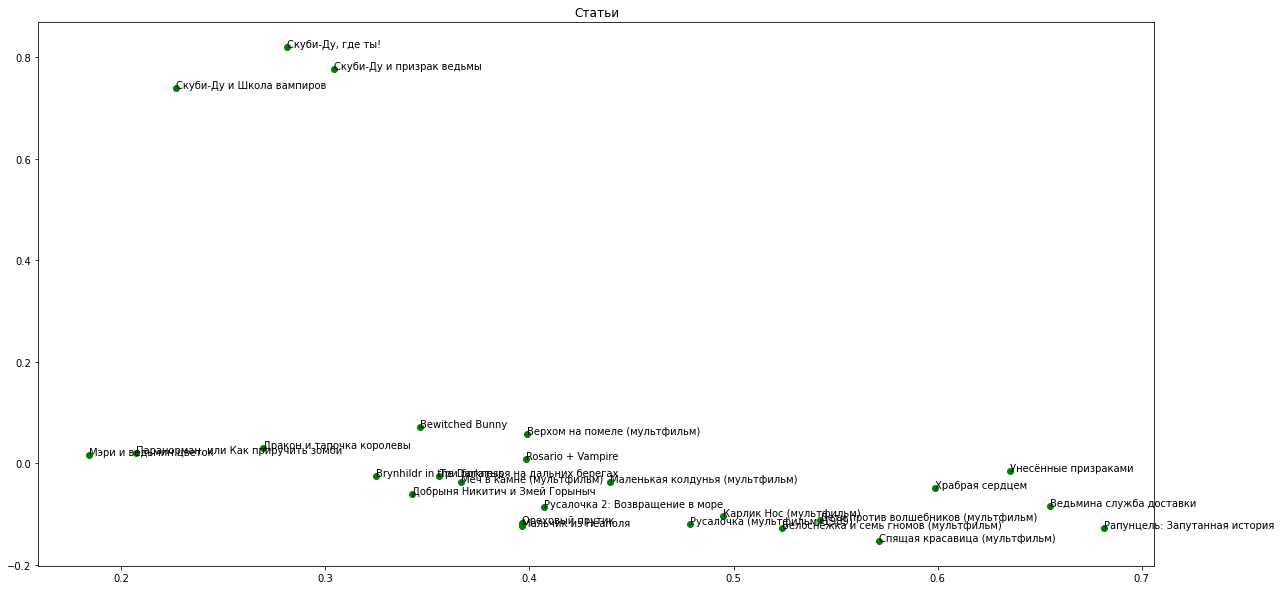

In [18]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
coords = svd.fit_transform(articles_tfidf)
plt.figure(figsize=(20, 10))
plt.scatter(coords[:, 0], coords[:, 1], color='green')
plt.title('Статьи') 

for i, article in enumerate(articles):
    plt.annotate(article[0], xy=(coords[i, 0], coords[i, 1]))
plt.show()

Похожие тексты действительно находятся рядом: например, все статьи про Скуби-Ду на графике в одной области, две "Русалочки" тоже недалеко друг от друга. Аниме "Унесенные призраками" и "Ведьмина служба доставки", созданные одной студией, оказались рядом. 

## Сайт RusVectores

### 1. Раздел похожие слова

Посмотрим на семантические ассоциаты для слова *мечта*:

**НКРЯ**
мечтание NOUN 0.75

греза NOUN 0.70

грез NOUN 0.70

мечтать VERB 0.65

мечта PROPN 0.57

несбыточный ADJ 0.57

утопия NOUN 0.56

идеал NOUN 0.55

надежда NOUN 0.55

фантазия NOUN 0.53


**НКРЯ и Wikipedia**

мечтание NOUN 0.70

надежда NOUN 0.63

мечтать VERB 0.59

греза NOUN 0.59

несбыточный ADJ 0.59

желание NOUN 0.58

грез NOUN 0.58

чаяние NOUN 0.56

мечта PROPN 0.55

фантазия NOUN 0.55


**Новостной корпус**

ярзабковска ADV 0.41

сбываться VERB 0.41


**GeoWAC fastText**

мечтание 0.74

несбыточный 0.69

мечтать 0.66

сбываться 0.63

заветный 0.63

грез 0.61

греза 0.60

мечтатель 0.59

воплощать 0.59

желанье 0.58


**Тайга**

мечта VERB 0.76

мечтание NOUN 0.75

мечта PROPN 0.73

несбыточный ADJ 0.68

греза NOUN 0.66

грез NOUN 0.62

несбыться VERB 0.62

мечтать VERB 0.57

сбываться VERB 0.54

грезить VERB 0.53

Слово *мечта* распространенное, четких выводов о содержании корпусов сделать нельзя, так как соседи одни и те же -- мечтание, греза, желание, сбываться. В НКРЯ и Википедия, кажется, больше разнообразных текстов, чем в Тайге или GeoWac, так как мы видим больше слов с разными корнями, а не только производные от мечта и греза. 

Новостной корпус наиболее отличается от остальных из-за специфики содержания (в нем только новостные тексты, а абстрактные понятия мы скорее ожидаем встретить в художественных)

Посмотрим на ассоциаты для термина *аффикс*:

**НКРЯ**

лексический ADJ 0.61

фонема NOUN 0.59

суффикс NOUN 0.58

лексема NOUN 0.57

синтаксический ADJ 0.57

существительное ADJ 0.56

глагольный ADJ 0.55

прилагательное NOUN 0.55

грамматический ADJ 0.54

прилагательное ADJ 0.53

**НКРЯ и Wikipedia**

суффикс NOUN 0.77

морфема NOUN 0.73

местоимение NOUN 0.72

глагольный ADJ 0.72

глагол NOUN 0.72

падежный ADJ 0.71

прилагательное ADJ 0.70

существительное ADJ 0.70

флексия NOUN 0.67

инфинитив NOUN 0.67

**Новостной корпус** -- Модели неизвестно слово "аффикс_NOUN"

**GeoWAC fastText**

суффикс 0.78

существительное 0.64

глагол 0.63

прилагательное 0.60

местоимение 0.59

наречие 0.56

согласная 0.54

гласная 0.52

падеж 0.51

фразеологизм 0.51

**Тайга**

суффикс NOUN 0.66

местоимение NOUN 0.59

фонема NOUN 0.56

прилагательное ADJ 0.53

глагольный ADJ 0.52

Интересно, что в НКРЯ ассоциаты прилагательные лексический, грамматический, синтаксический, то есть виды аффиксов, в других корпусах -- преимущественно существительные, другие термины, связанные с лингвистикой. В Новостном корпусе и вовсе нет слова аффикс, так как тексты этого корпуса не научные. В Тайге и GeoWAC, по сравнению с НКРЯ и Википедией, более примитивные соседи, что о говорит о том, что и в этих корпусах доля научных текстов значительно ниже, чем в НКРЯ. 

Посмотрим на ассоциаты для слова *полотенце*:

**НКРЯ**

простыня NOUN 0.69

салфетка NOUN 0.65

тряпка NOUN 0.62

платок NOUN 0.62

рушник NOUN 0.61

тряпочка NOUN 0.61

мочалка NOUN 0.60

одеяло NOUN 0.57

рукомойник NOUN 0.57

тряпица NOUN 0.57

**НКРЯ и Wikipedia**

простыня NOUN 0.74

платок NOUN 0.70

салфетка NOUN 0.69

тряпка NOUN 0.65

одеяло NOUN 0.65

скатерть NOUN 0.64

тряпица NOUN 0.63

белье NOUN 0.63

передник NOUN 0.62

халат NOUN 0.62

**Новостной корпус**

салфетка NOUN 0.60

брюки NOUN 0.56

**GeoWAC fastText**

салфетка 0.71

простыня 0.68

тапочка 0.66

мочалка 0.65

одеяло 0.65

халат 0.63

махровый 0.62

скатерть 0.61

белье 0.61

пеленок 0.61

**Тайга**

простыня NOUN 0.72

салфетка NOUN 0.70

вытереться VERB 0.68

мочалка NOUN 0.67

платок NOUN 0.67

тряпка NOUN 0.63

тряпица NOUN 0.63

простыня ADJ 0.63

наволочка NOUN 0.63

плед NOUN 0.63


Для этого слова результаты для всех корпусов (кроме Новостного) наиболее похожие и однозначные: первые две позиции занимают слова простыня и салфетка, а вот последующее распределение зависит от содержания корпуса. В НКРЯ есть старые тексты, поэтому и среди ассоциатов видим необычные варианты -- рушник, рукомойник, тряпица. В НКРЯ и Википедии, под влиянием последней, платок располагается на втором месте, выше салфетки и тряпки, а также присутствуют другие элементы быта - скатерть, халат, передник.

Интересно, что глагол оказался только в выдачи Тайги. 

### Раздел визуализация

Возьмем слова зависть, стыд, удивление, отвращение, восхищение, грусть, радость, злость, страх, разочарование. Картинки с визуализацией размещены в папке "Визуализация". 

### Раздел калькулятор
Посмотрим, какой результат покажут модели для пропорции лингвист - язык, филолог - ?

**НКРЯ**

латынь NOUN 0.56

словесность NOUN 0.51

грамматика NOUN 0.48

хрестоматия NOUN 0.47

литература NOUN 0.46

**НКРЯ и Wikipedia**

латынь NOUN 0.54

языке NOUN 0.53

язык PROPN 0.50

церковнославянский ADJ 0.48

языке VERB 0.47

**Новостной корпус**

русский ADJ 0.45

**GeoWAC fastText**

английский 0.66

филология 0.64

языке 0.62

преподавание 0.58

русский 0.57

**Тайга**

язык PROPN 0.53

грамматика NOUN 0.53

латынь NOUN 0.52

диалект NOUN 0.52

идиш NOUN 0.49


Выдача модели на основе НКРЯ наиболее разнообразна, так как в этом корпусе, вероятно, больше текстов, где упоминаются слова лингвист и филолог, чего не скажешь о других корпусах. В целом модели скорее не видят различий между этими словами. 

### Раздел 2D текст

Возьмем первое предложение из романа "Мастер и Маргарита", с которым уже работали выше, и пословицу "Без труда не вытащить и рыбку из пруда". 

Получаем вот такие варианты для предложения:

*Вчера	осенью	в	день	довольно	сильного	солнца	в	Одессе	на	улицах	улицах	появляются	три	людей*

*Как-то	ночью	в	месяц	столь	солнца	обеда	в	Петербурге	на	официальных	домах	возникли	четыре	военнослужащих*

*Вечером	зимой	в	вечер	чрезвычайно	раннего	лета	в	Киеве	на	московских	озере	имеются	Два	евреев*

*Наконец	летом	в	миг	бесконечно	большого	неба	в	Санкт-Петербурге	на	черных	горах	начались	двое	гостей*

*Утром	вечером	в	полчаса	праздника	обычного	праздника	в	Париже	на	открытых	полях	появилась	Четыре	крестьян*


Замены скорее неадекватные, полностью искажающие смысл предложения. Меняется и время года, и место действия, и число людей, а также то, что это за люди (вместо граждан -- евреи и крестьяне)

Для пословицы: 

*Без	трудом	не	купить	и	девушку	из	озера*

*Без	ума	не	взять	и	женщину	из	сада*

*Без	счастья	не	вывести	и	бутылку	из	залива*

*Без	усилий	не	найти	и	лошадь	из	водохранилища*

*Без	голода	не	поднять	и	еду	из	моста*

Замены еще более неадекватные, смысл пословицы совсем теряется, а предложения получаются абсурдными. 

## TF-IDF

2. Параметр token_pattern принимает регулярное выражение, которому должно соотвествовать каждое слово в словаре. Чтобы цифры не попадали в словарь, можно задать обучение модели так:

In [5]:
regex = '[а-яА-я]+' #если нам нужны не только русские слова: '[а-яА-яa-zA-Z]+'
tfidf_1 = TfidfVectorizer(
    analyzer="word",
    stop_words=stops,
    ngram_range = (1, 3), #число слов
    min_df = 3, #минимальное число вхождений
    token_pattern=regex
)

С помощью функции cosine_similarity и pandas создадим матрицу схожести текстов на основе их векторов:

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
sm = cosine_similarity(articles_tfidf)

In [16]:
import pandas as pd
df = pd.DataFrame(sm, columns=article_names, index=article_names)
df

,Белоснежка и семь гномов (мультфильм),Ведьмина служба доставки,Верхом на помеле (мультфильм),Дети против волшебников (мультфильм),Добрыня Никитич и Змей Горыныч,Дракон и тапочка королевы,Карлик Нос (мультфильм),Маленькая колдунья (мультфильм),Мальчик из Неаполя,Меч в камне (мультфильм),...,Скуби-Ду и призрак ведьмы,Скуби-Ду и Школа вампиров,"Скуби-Ду, где ты!",Спящая красавица (мультфильм),Три богатыря на дальних берегах,Унесённые призраками,Храбрая сердцем,Bewitched Bunny,Brynhildr in the Darkness,Rosario + Vampire
Белоснежка и семь гномов (мультфильм),1.000000,0.292333,0.143808,0.220115,0.121431,0.179821,0.208547,0.150106,0.135854,0.170720,...,0.063206,0.041694,0.086911,0.439205,0.123528,0.261208,0.297624,0.148002,0.102661,0.158875
Ведьмина служба доставки,0.292333,1.000000,0.321257,0.365360,0.162681,0.065369,0.277731,0.226747,0.156136,0.146678,...,0.129954,0.056315,0.104275,0.316139,0.173044,0.609075,0.290407,0.091131,0.327424,0.322007
Верхом на помеле (мультфильм),0.143808,0.321257,1.000000,0.180278,0.106093,0.141301,0.173076,0.179906,0.096347,0.097023,...,0.164969,0.079537,0.071800,0.130721,0.102420,0.287338,0.210435,0.148059,0.063716,0.088300
Дети против волшебников (мультфильм),0.220115,0.365360,0.180278,1.000000,0.181064,0.080540,0.266089,0.242413,0.261768,0.136337,...,0.073403,0.037811,0.101538,0.241817,0.236183,0.316917,0.252330,0.119066,0.117681,0.173346
Добрыня Никитич и Змей Горыныч,0.121431,0.162681,0.106093,0.181064,1.000000,0.075146,0.240668,0.089480,0.124330,0.081335,...,0.061117,0.031406,0.061845,0.129189,0.221127,0.169802,0.154587,0.072556,0.077857,0.121395
Дракон и тапочка королевы,0.179821,0.065369,0.141301,0.080540,0.075146,1.000000,0.069738,0.046369,0.047141,0.311271,...,0.077147,0.090757,0.023731,0.137870,0.074963,0.092582,0.258509,0.175611,0.034761,0.047898
Карлик Нос (мультфильм),0.208547,0.277731,0.173076,0.266089,0.240668,0.069738,1.000000,0.230184,0.197865,0.108028,...,0.082988,0.035106,0.086095,0.225371,0.134984,0.281434,0.232394,0.107315,0.084507,0.160573
Маленькая колдунья (мультфильм),0.150106,0.226747,0.179906,0.242413,0.089480,0.046369,0.230184,1.000000,0.313767,0.115937,...,0.162724,0.027210,0.075447,0.182808,0.151805,0.139749,0.239525,0.204417,0.067282,0.069002
Мальчик из Неаполя,0.135854,0.156136,0.096347,0.261768,0.124330,0.047141,0.197865,0.313767,1.000000,0.127251,...,0.049806,0.020063,0.062069,0.144441,0.104591,0.124475,0.185838,0.159527,0.036661,0.082000
Меч в камне (мультфильм),0.170720,0.146678,0.097023,0.136337,0.081335,0.311271,0.108028,0.115937,0.127251,1.000000,...,0.058402,0.064379,0.065733,0.193585,0.070596,0.160301,0.246253,0.107089,0.054373,0.093699


Посмотрим, какие тексты наиболее похожи на текст про мультфильм "Ведьмина служба доставки":

In [20]:
df["Ведьмина служба доставки"].sort_values(ascending=False)

Ведьмина служба доставки                 1.000000
Унесённые призраками                     0.609075
Рапунцель: Запутанная история            0.388703
Дети против волшебников (мультфильм)     0.365360
Brynhildr in the Darkness                0.327424
Rosario + Vampire                        0.322007
Верхом на помеле (мультфильм)            0.321257
Спящая красавица (мультфильм)            0.316139
Белоснежка и семь гномов (мультфильм)    0.292333
Храбрая сердцем                          0.290407
Карлик Нос (мультфильм)                  0.277731
Русалочка (мультфильм, 1989)             0.245649
Маленькая колдунья (мультфильм)          0.226747
Три богатыря на дальних берегах          0.173044
Русалочка 2: Возвращение в море          0.169138
Добрыня Никитич и Змей Горыныч           0.162681
Мэри и ведьмин цветок                    0.156344
Мальчик из Неаполя                       0.156136
Ореховый прутик                          0.147372
Меч в камне (мультфильм)                 0.146678


Попробуем визуализировать матрицу близости:

In [21]:
import seaborn as sns

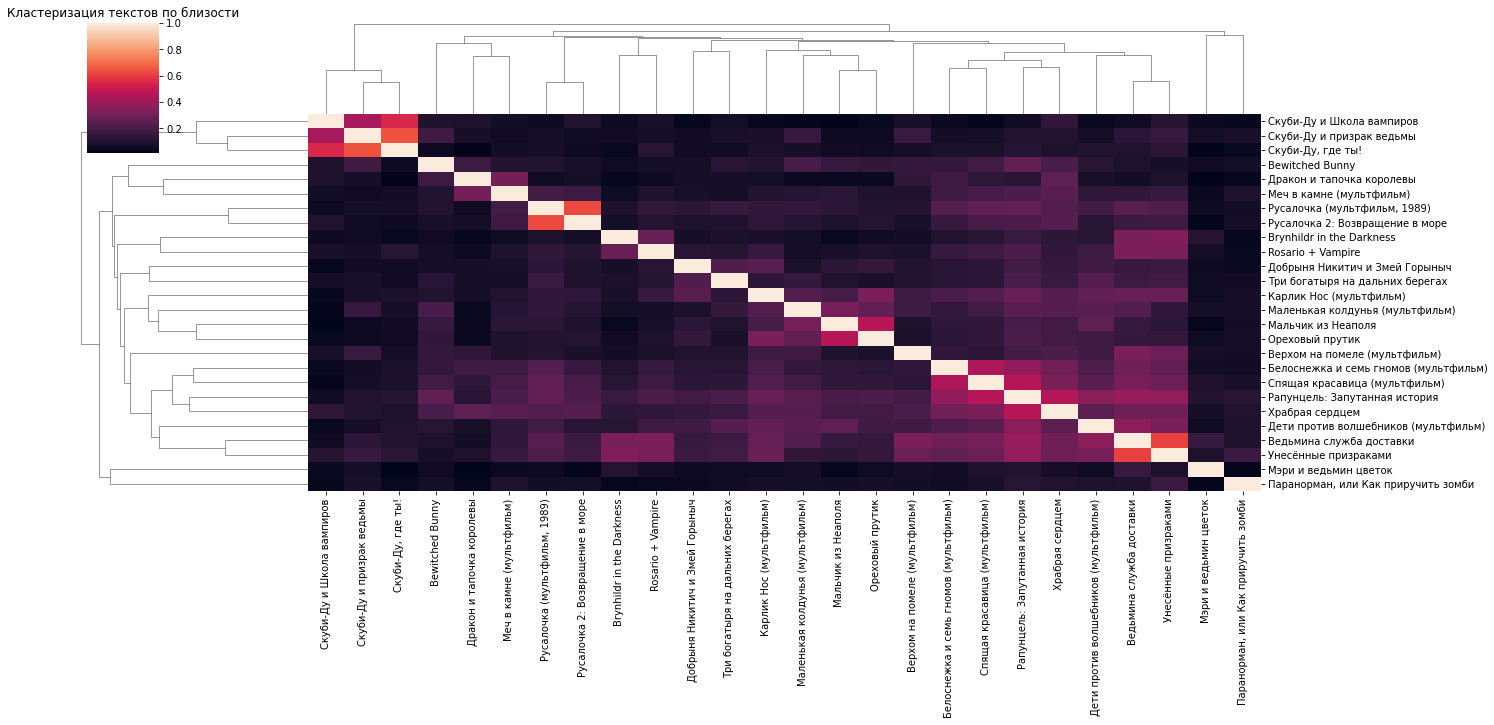

In [41]:
sns.clustermap(df, figsize=(20, 10))
plt.title('Кластеризация текстов по близости')
plt.show()

Как мы можем заметить, в целом тексты кластеризируются адекватно (например, все статьи про Скуби-Ду оказались в одном кластере), две "Русалочки" также объединены. 